In [1]:
import pandas as pd
import numpy as np

import os
import pathlib

import cv2 #영상처리에 사용하는 오픈소스 라이브러리, 컴퓨터가 사람 눈처럼 인식할 수 있게 처리
from PIL import Image # 파이썬 이미지 처리 pillow 라이브러리
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #imagedatagenerater는 이미지를 학습시킬 때 학습 데이터의 양이 적을 경우 학습데이터를 조금씩 변형 시켜서 학습데이터의 양을 늘리는 방식중 하나
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

#난수 랜덤성 고정
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


### setup_data

In [4]:
import numpy as np
import os
import gzip
import urllib.request

from keras.models import load_model

class GTSRB:
    def __init__(self):
        imgs_path = "Train"
        data_list = []
        labels_list = []

        result_class = [3,7, 9, 10, 11, 12, 13, 17, 18, 25, 35, 38]

        for i in result_class:
            i_path = os.path.join(imgs_path, str(i)) # 3, 7, 9, 10, 11, 12,13, 17, 18, 25, 35, 38
            num = 0
            for img in os.listdir(i_path):
          
                im = Image.open(i_path +'/'+ img)
                im = im.resize((32,32))
                im = np.array(im)

                data_list.append(im)
                labels_list.append(i)
                num = num + 1
                if num == 1000:
                    break;

        data = np.array(data_list)
        labels = np.array(labels_list)

        labels = to_categorical(labels)

        VALIDATION_SIZE = 5000
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(np.array(data), labels, test_size=0.4)    

    @staticmethod
    def print():
        return "GTSRB"


class GTSRBModel:
    def __init__(self, restore, session=None):
        self.num_channels = 3
        self.image_size = 32
        self.num_labels = 12
        
        model = Sequential()

        model.add(Conv2D(64, (3, 3),input_shape=(32, 32, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dense(39))

        model.load_weights(restore)

        self.model = model

    def predict(self, data):
        return self.model(data)

In [5]:
data = GTSRB()

In [6]:
print(data.x_train.shape)
print(data.x_test.shape)
print(data.y_train.shape)
print(data.y_test.shape)

(7200, 32, 32, 3)
(4800, 32, 32, 3)
(7200, 39)
(4800, 39)


In [7]:
data.y_train.shape

(7200, 39)

In [8]:
data.x_train[0].shape

(32, 32, 3)

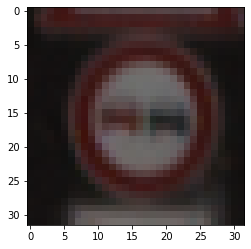

In [9]:
plt.imshow(data.x_train[5])

### train_models

In [10]:
data.x_train, data.y_train, data.x_test, data.y_test =data.x_train/255, data.y_train/255, data.x_test/255, data.y_test/255

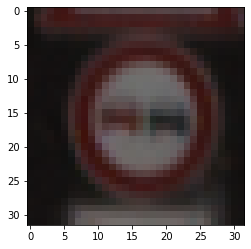

In [11]:
plt.imshow(data.x_train[5])

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os


def train(data, file_name, num_epochs=50, batch_size=128):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    IMG_HEIGHT = 32
    IMG_WIDTH = 32

    # 첫번째 Convolutional Layer : 입력 데이터로부터 특징을 추출
    model.add(Conv2D(filters=96, kernel_size=3, activation='relu', input_shape=data.x_train.shape[1:]))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # 두번째 Convolutional Layer
    model.add(Conv2D(filters=192, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25)) # 인풋데이터의 25%를 무작위로 0으로 만듦

    # 세번째 Convolutional Layer
    model.add(Conv2D(filters=192, kernel_size=3, activation='relu')) # 특징을 추출하는 기능을 하는 필터, 비선형 값으로 바꿔주는 activation 함수->relu
    # model.add(GlobalAveragePooling2D())
    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(39, activation='softmax'))


    # 모델 컴파일 하기
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # 모델 핏하기
    EPOCHS = num_epochs
    model.fit(data.x_train, data.y_train,
              validation_data = (data.x_test, data.y_test), 
              epochs=EPOCHS, steps_per_epoch=60
              )

    if file_name != None:
        model.save(file_name)

    return model


if not os.path.isdir('models'):
    os.makedirs('models')

model = train(data, "models/gtsrb_classifier", num_epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 192)       166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 192)         0

In [13]:
loss, accuracy = model.evaluate(data.x_train, data.y_train)

print('test set accuracy: ', accuracy * 100)

225/225 [==============================] - 1s 3ms/step - loss: 7.3155e-04 - accuracy: 0.9215
test set accuracy:  92.15278029441833


In [14]:
loss, accuracy = model.evaluate(data.x_test, data.y_test)

print('test set accuracy: ', accuracy * 100)

150/150 [==============================] - 0s 3ms/step - loss: 7.3312e-04 - accuracy: 0.9169
test set accuracy:  91.68750047683716


### worker : 에러나서 추가

In [15]:
## setup_mnist.py -- mnist data and model loading code
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

## Modified for MagNet's use.

## worker.py -- evaluation code
##
## Copyright (C) 2017, Dongyu Meng <zbshfmmm@gmail.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import matplotlib
matplotlib.use('Agg')
from scipy.stats import entropy
from numpy.linalg import norm
from matplotlib.ticker import FuncFormatter
from keras.models import Sequential, load_model
from keras.activations import softmax
from keras.layers import Lambda
import numpy as np
import pylab
import os
import matplotlib.pyplot as plt


class AEDetector:
    def __init__(self, path, p=1):
        """
        Error based detector.
        Marks examples for filtering decisions.

        path: Path to the autoencoder used.
        p: Distance measure to use.
        """

        self.model = load_model(path)
        self.path = path
        self.p = p

    def mark(self, X):
        diff = np.abs(X - self.model.predict(X)) # input X와 예측값 X'(autoencoder를 통해 노이즈가 더해진 값) 의 오차 값
        marks = np.mean(np.power(diff, self.p), axis=(1,2,3)) # 오차값의 분산
        return marks

    def print(self):
        return "AEDetector:" + self.path.split("/")[-1]


class IdReformer:
    def __init__(self, path="IdentityFunction"):
        """
        Identity reformer.
        Reforms an example to itself.
        """
        self.path = path
        self.heal = lambda X: X

    def print(self):
        return "IdReformer:" + self.path


class SimpleReformer:
    def __init__(self, path):
        """
        Reformer.
        Reforms examples with autoencoder. Action of reforming is called heal.

        path: Path to the autoencoder used.
        """
        self.model = load_model(path)
        self.path = path

    def heal(self, X):
        X = self.model.predict(X) # autoencoder로 X값 재구성
        return np.clip(X, 0.0, 1.0)

    def print(self):
        return "SimpleReformer:" + self.path.split("/")[-1]


def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M)) # Xp와 Xr의 분포의 entropy 
    # KL divergence: Q(one autoencoder)를 기반으로 했을 때의 cross entropy와 P(magnet)를 기반으로 했을 때의 entropy의 차이



class DBDetector:
    def __init__(self, reconstructor, prober, classifier, option="jsd", T=1):
        """
        Divergence-Based Detector.

        reconstructor: One autoencoder.
        prober: Another autoencoder.
        classifier: Classifier object.
        option: Measure of distance, jsd as default.
        T: Temperature to soften the classification decision.
        """
        self.prober = prober
        self.reconstructor = reconstructor
        self.classifier = classifier
        self.option = option
        self.T = T

    def mark(self, X):
        return self.mark_jsd(X)

    def mark_jsd(self, X):
        Xp = self.prober.heal(X) # 1번 autoencoder로 생성한 이미지 
        Xr = self.reconstructor.heal(X) #2번 autoencoder로 생성한 이미지 
        Pp = self.classifier.classify(Xp, option="prob", T=self.T) # Xp의 확률
        Pr = self.classifier.classify(Xr, option="prob", T=self.T) # Xr의 확률

        marks = [(JSD(Pp[i], Pr[i])) for i in range(len(Pr))]
        return np.array(marks)

    def print(self):
        return "Divergence-Based Detector"


class Classifier:
    def __init__(self, classifier_path):
        """
        Keras classifier wrapper.
        Note that the wrapped classifier should spit logits as output.

        classifier_path: Path to Keras classifier file.
        """
        self.path = classifier_path
        self.model = load_model(classifier_path)
        self.softmax = Sequential()
        self.softmax.add(Lambda(lambda X: softmax(X, axis=1)))

    def classify(self, X, option="logit", T=1):
        if option == "logit":
            return self.model.predict(X)
        if option == "prob":
            logits = self.model.predict(X)/T
            return self.softmax.predict(logits)

    def print(self):
        return "Classifier:"+self.path.split("/")[-1]


class Operator:
    def __init__(self, data, classifier, det_dict, reformer):
        """
        Operator.
        Describes the classification problem and defense.

        data: Standard problem dataset. Including train, test, and validation.
        classifier: Target classifier.
        reformer: Reformer of defense.
        det_dict: Detector(s) of defense.
        """

        self.data = data
        self.classifier = classifier
        self.det_dict = det_dict 
        self.reformer = reformer
        self.normal = self.operate(AttackData(data.x_train, np.argmax(data.y_train, axis=1), "Normal"))
        

    def get_thrs(self, drop_rate):
        """
        Get filtering threshold by marking validation set.
        """
        thrs = dict()
        for name, detector in self.det_dict.items():
            num = int(len(data.x_test) * drop_rate[name])
            marks = detector.mark(data.x_test)
            marks = np.sort(marks)
            thrs[name] = marks[-num]
        return thrs

    def operate(self, untrusted_obj):
        """
        For untrusted input(normal or adversarial), classify original input and
        reformed input. Classifier is unaware of the source of input.

        untrusted_obj: Input data.
        """

        X = untrusted_obj.data
        Y_true = untrusted_obj.labels


        X_prime = self.reformer.heal(X) # autoencoder 값으로 재구성
        Y = np.argmax(self.classifier.classify(X), axis=1) # 원본 input X 분류
        Y_judgement = (Y == Y_true[:len(X_prime)]) # 실제 label과 X 분류 label 비교
        Y_prime = np.argmax(self.classifier.classify(X_prime), axis=1)  # autoencoder로 재구성한 X' 분류
        Y_prime_judgement = (Y_prime == Y_true[:len(X_prime)])  # 실제 label과 X' 분류 label 비교
        return np.array(list(zip(Y_judgement, Y_prime_judgement)))

    def filter(self, X, thrs):
        """
        untrusted_obj: Untrusted input to test against.
        thrs: Thresholds.

        return:
        all_pass: Index of examples that passed all detectors.
        collector: Number of examples that escaped each detector.
        """
        collector = dict()
        all_pass = np.array(range(10000)) #Index
        for name, detector in self.det_dict.items():
            marks = detector.mark(X) #  KL divergnece: Xp와 Xr의 분포의 entropy 
            idx_pass = np.argwhere(marks < thrs[name]) # KL divergnece가 thershold보다 작을 경우 pass, 클 경우 reject
            collector[name] = len(idx_pass) # pass가 된 수
            all_pass = np.intersect1d(all_pass, idx_pass) # 전체 index array와 pass된 array의 교집합
        return all_pass, collector

    def print(self):
        components = [self.reformer, self.classifier]
        return " ".join(map(lambda obj: getattr(obj, "print")(), components))


class AttackData:
    def __init__(self, examples, labels, name=""):
        """
        Input data wrapper. May be normal or adversarial.

        examples: Path or object of input examples.
        labels: Ground truth labels.
        """
        # if isinstance(examples, str): 
        #   self.data = load_obj(examples)
        # else: 

        self.data = examples
        self.labels = labels
        self.name = name

    def print(self):
        return "Attack:"+self.name


class Evaluator:
    def __init__(self, operator, untrusted_data, graph_dir="./graph"):
        """
        Evaluator.
        For strategy described by operator, conducts tests on untrusted input.
        Mainly stats and plotting code. Most methods omitted for clarity.

        operator: Operator object.
        untrusted_data: Input data to test against.
        graph_dir: Where to spit the graphs.
        """
        self.operator = operator
        self.untrusted_data = untrusted_data # attacked data
        self.graph_dir = graph_dir
        self.data_package = operator.operate(untrusted_data)

    def bind_operator(self, operator):
        self.operator = operator
        self.data_package = operator.operate(self.untrusted_data)

    def load_data(self, data):
        self.untrusted_data = data
        self.data_package = self.operator.operate(self.untrusted_data)

    def get_normal_acc(self, normal_all_pass):
        """
        traning data에 대한 정확도

        Break down of who does what in defense. Accuracy of defense on normal
        input.

        both: Both detectors and reformer take effect
        det_only: detector(s) take effect
        ref_only: Only reformer takes effect
        none: Attack effect with no defense
        """
        normal_tups = self.operator.normal
        num_normal = len(normal_tups)
        filtered_normal_tups = normal_tups[normal_all_pass]

        both_acc = sum(1 for _, XpC in filtered_normal_tups if XpC)/num_normal # detector and refomer
        det_only_acc = sum(1 for XC, XpC in filtered_normal_tups if XC)/num_normal # only detector
        ref_only_acc = sum([1 for _, XpC in normal_tups if XpC])/num_normal # only reformer
        none_acc = sum([1 for XC, _ in normal_tups if XC])/num_normal # no defense

        return both_acc, det_only_acc, ref_only_acc, none_acc

    def get_attack_acc(self, attack_pass):
        """
        attacked data에 대한 정확도 
        """
        attack_tups = self.data_package
        num_untrusted = len(attack_tups)
        filtered_attack_tups = attack_tups[attack_pass]


        both_acc = 1 - sum(1 for _, XpC in filtered_attack_tups if not XpC)/num_untrusted # detector and refomer
        det_only_acc = 1 - sum(1 for XC, XpC in filtered_attack_tups if not XC)/num_untrusted # only detector
        ref_only_acc = sum([1 for _, XpC in attack_tups if XpC])/num_untrusted # only reformer
        none_acc = sum([1 for XC, _ in attack_tups if XC])/num_untrusted # no defense
        
        return both_acc, det_only_acc, ref_only_acc, none_acc

    def plot_various_confidences(self, graph_name, drop_rate,
                                 idx_file="example_idx",
                                 confs=(0.0, 10.0),
                                 get_attack_data_name=lambda c: "example_carlini_"+str(c)):
        """
        Test defense performance against Carlini L2 attack of various confidences.

        graph_name: Name of graph file.
        drop_rate: How many normal examples should each detector drops?
        idx_file: Index of adversarial examples in standard test set.
        confs: A series of confidence to test against.
        get_attack_data_name: Function mapping confidence to corresponding file.
        """
        pylab.rcParams['figure.figsize'] = 6, 4
        fig = plt.figure(1, (6, 4))
        ax = fig.add_subplot(1, 1, 1)

        idx = orig_labels
        # idx = original_labels_list
        X, _, Y = prepare_data(self.operator.data, idx)


        det_only = []
        ref_only = []
        both = []
        none = []

        print("\n==========================================================")
        print("Drop Rate:", drop_rate)
        thrs = self.operator.get_thrs(drop_rate)

        all_pass, _ = self.operator.filter(self.operator.data.x_train, thrs)
        all_on_acc, _, _, _ = self.get_normal_acc(all_pass)

        print("Classification accuracy with all defense on:", all_on_acc)

        for confidence in confs:
            # f = get_attack_data_name(confidence)
            self.load_data(AttackData(ad_examples1, orig_labels, "GTSRB FSGM"))

            print("----------------------------------------------------------")
            print("Confidence:", confidence)
            all_pass, detector_breakdown = self.operator.filter(self.untrusted_data.data, thrs)
            both_acc, det_only_acc, ref_only_acc, none_acc = self.get_attack_acc(all_pass)
            print(detector_breakdown)
            both.append(both_acc)
            det_only.append(det_only_acc)
            ref_only.append(ref_only_acc)
            none.append(none_acc)

        size = 2.5

        print("With detector & reformer: ", both_acc)
        print("With detector: ",det_only_acc)
        print("With reformer: ", ref_only_acc)
        print("No Defense: ",none_acc)

        # print("With detector & reformer: ", both)
        # print("With detector: ",det_only)
        # print("With reformer: ", ref_only)
        # print("No Defense: ",none)

        plt.plot(confs, none, c="green", label="No Defense", marker="x", markersize=size,alpha=0.5)
        # plt.plot(confs, det_only, c="orange", label="With detector", marker="o", markersize=size,alpha=0.5)
        # plt.plot(confs, ref_only, c="blue", label="With reformer", marker="^", markersize=size,alpha=0.5)
        plt.plot(confs, both, c="red", label="With detector & reformer", marker="s", markersize=size,alpha=0.5)

        pylab.legend(loc='lower left', bbox_to_anchor=(0.02, 0.1), prop={'size':8})
        plt.grid(linestyle='dotted')
        plt.xlabel(r"Confidence in Carlini $L^2$ attack")
        plt.ylabel("Classification accuracy")
        plt.xlim(min(confs)-1.0, max(confs)+1.0)
        plt.ylim(-0.05, 1.05)
        ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

        save_path = os.path.join(self.graph_dir, graph_name+".pdf")
        plt.savefig(save_path)
        plt.clf()

    def print(self):
        return " ".join([self.operator.print(), self.untrusted_data.print()])

In [16]:
classifier = Classifier("./models/gtsrb_classifier")
loss, accuracy = classifier.model.evaluate(data.x_test, data.y_test)


print('test set accuracy: ', accuracy * 100)

150/150 [==============================] - 1s 3ms/step - loss: 7.3312e-04 - accuracy: 0.9169
test set accuracy:  91.68750047683716


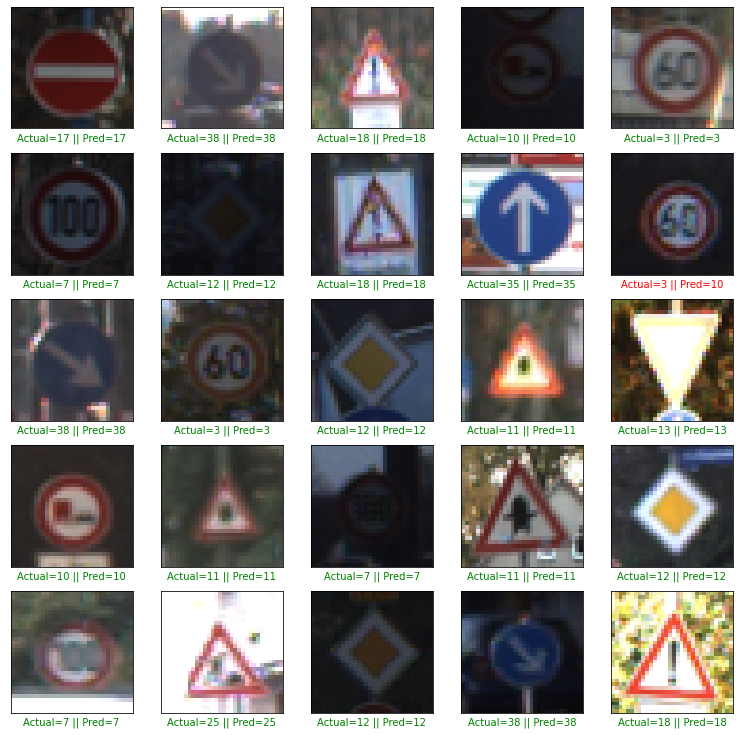

In [17]:
plt.figure(figsize = (13, 13))

start_index = 100
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(model.predict(data.x_test[start_index+i].reshape(-1,32,32,3)))
    prediction = pred
    actual = np.argmax(data.y_test[start_index + i])
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(data.x_test[start_index + i])
plt.show()

### FGSM -> PGD

In [18]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [19]:
import natsort

class GTSRB_test:
    def __init__(self):
        imgs_path = "Test"
        data_list = []
        labels_list = []
        
        for img in natsort.natsorted(os.listdir(imgs_path)):
            im = Image.open(imgs_path +'/'+ img)
            im = im.resize((32,32))
            im = np.array(im)
            data_list.append(im)
        data_test = np.array(data_list)
        
        for i in range(len(testinfo.ClassId)):
            labels_list.append(testinfo.ClassId[i])
        
        labels_test = np.array(labels_list)

        labels_test_index = []
        for i in range(len(labels_test)):
            if (labels_test[i] == 3) | (labels_test[i] == 7) | (labels_test[i] == 9) | (labels_test[i] == 10) | (labels_test[i] == 11) | (labels_test[i] == 12) | (labels_test[i] == 13) | (labels_test[i] == 17) | (labels_test[i] == 18) | (labels_test[i] == 25) | (labels_test[i] == 35) | (labels_test[i] == 38):
                labels_test_index.append(i)

        test_data = []
        test_label = []
        for i in labels_test_index:
            test_data.append(data_test[i])
            test_label.append(labels_test[i])

        data_test = np.array(test_data)   
        labels_test = np.array(test_label)

        labels_test = to_categorical(labels_test)
        
        self.x_test = data_test
        self.y_test = labels_test    

    @staticmethod
    def print():
        return "GTSRB_test"

In [21]:
data_test = GTSRB_test()

In [22]:
data_test.x_test.shape

(6180, 32, 32, 3)

38


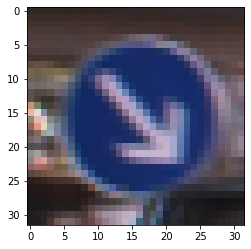

In [23]:
print(np.argmax(data_test.y_test[0]))
plt.imshow(data_test.x_test[0])

In [24]:
# 이미지가 MobileNetV2에 전달될 수 있도록 전처리해주는 헬퍼 메서드(helper function)
def tf_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_tf_label(labels):
    label = tf.cast(labels, tf.int32)
    label = tf.reshape(label,[1,39])
    return label

In [25]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    input_img = tf.reshape(input_image,[1,32,32,3])
    prediction = model(input_img)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

In [26]:
def PGD_attack(model,test_x,test_y,eps,step_size,num_steps):
    
    prog = 0 # 몇 번째 이미지까지 왔는지


    correct = 0
    adv_examples = []
    save_adv_examples = []
    save_original_output = []
    
    for i in range(len(test_x)):
        data_nat = test_x[i]
        target = test_y[i]

        result = model.predict(data_nat.reshape(1,32,32,3))
        init_output = int(np.argmax(result))

        ########################################################################
        data = data_nat + np.random.uniform(-eps, eps, data_nat.shape)
        data = np.clip(data,0,255)
        ########################################################################

        img =  tf_preprocess(data)
        label = get_tf_label(target)

        ########################################################################
        # adv_x = img + eps*perturbations # FGSM
        # adv_x = tf.clip_by_value(adv_x, 0, 1) # FGSM
        # 아래로 변경
        adv_x = img
        for num_step in range(num_steps):
          perturbations = create_adversarial_pattern(adv_x, label) # signed_grad를 리턴한 값
          adv_x = img + step_size * perturbations # PGD
          adv_x = tf.clip_by_value(adv_x,img-eps,img+eps)
          adv_x = tf.clip_by_value(adv_x, 0, 1)


        output = model.predict(adv_x)

        final_pred = int(np.argmax(output))

        if final_pred == int(np.argmax(target)):
            correct += 1
            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))
        else:
            if len(adv_examples) < 5:
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))

        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(init_output)

        prog += 1

        if prog%100 == 0:
          print(prog)


    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

In [28]:
eps = 0.3 # 0.02
step_size = 2.5 * eps/100
num_steps = 20 # 50

# 각 엡실론에 대해 테스트 함수를 실행합니다
acc, ex, ad_examples, orig_labels = PGD_attack(model, data_test.x_test, data_test.y_test, eps,step_size,num_steps) # 시간

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
Epsilon: 0.3	Test Accuracy = 4029 / 6180 = 0.6519417475728155


In [29]:
print(len(ad_examples))

6180


### test accuracy 변화
** epsilon만 변경 (step_size = 0.01, num_steps = 10)
eps = 0.001
eps = 0.01
eps = 0.02
eps = 0.05
eps = 0.1



- ad_examples : epsilon 0,02로 공격한 데이터 셋
- orig_labels : 공격 전 예측 값

In [ ]:
print(orig_labels[1])
plt.imshow(ad_examples[11])

In [ ]:
np.argmax(model.predict(tf.reshape(ad_examples[11],[1,32,32,3])))

In [ ]:
ad_examples1 = np.array(ad_examples)
orig_labels1 = to_categorical(orig_labels)

In [ ]:
loss, accuracy = model.evaluate(ad_examples1, orig_labels1)

print('test set accuracy: ', accuracy * 100)

In [ ]:
classifier = Classifier("./models/gtsrb_classifier")
loss, accuracy = classifier.model.evaluate(ad_examples1, orig_labels1)

print('test set accuracy: ', accuracy * 100)

### utils

In [ ]:
## utils.py -- utility functions
##
## Copyright (C) 2017, Dongyu Meng <zbshfmmm@gmail.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import pickle
import os
import numpy as np


def prepare_data(dataset, idx):
    """
    Extract data from index.

    dataset: Full, working dataset. Such as MNIST().
    idx: Index of test examples that we care about.
    return: X, targets, Y
    """
    return dataset.x_test[idx], dataset.y_test[idx], np.argmax(dataset.y_test[idx], axis=1)


def save_obj(obj, name, directory='./attack_data/'):
    with open(os.path.join(directory, name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name, directory='./attack_data/'):
    if name.endswith(".pkl"): name = name[:-4]
    with open(os.path.join(directory, name + '.pkl'), 'rb') as f:
        return pickle.load(f)

### worker

In [ ]:
## setup_mnist.py -- mnist data and model loading code
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

## Modified for MagNet's use.

## worker.py -- evaluation code
##
## Copyright (C) 2017, Dongyu Meng <zbshfmmm@gmail.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import matplotlib
matplotlib.use('Agg')
from scipy.stats import entropy
from numpy.linalg import norm
from matplotlib.ticker import FuncFormatter
from keras.models import Sequential, load_model
from keras.activations import softmax
from keras.layers import Lambda
import numpy as np
import pylab
import os
import matplotlib.pyplot as plt


class AEDetector:
    def __init__(self, path, p=1):
        """
        Error based detector.
        Marks examples for filtering decisions.

        path: Path to the autoencoder used.
        p: Distance measure to use.
        """

        self.model = load_model(path)
        self.path = path
        self.p = p

    def mark(self, X):
        diff = np.abs(X - self.model.predict(X)) # input X와 예측값 X'(autoencoder를 통해 노이즈가 더해진 값) 의 오차 값
        marks = np.mean(np.power(diff, self.p), axis=(1,2,3)) # 오차값의 분산
        return marks

    def print(self):
        return "AEDetector:" + self.path.split("/")[-1]


class IdReformer:
    def __init__(self, path="IdentityFunction"):
        """
        Identity reformer.
        Reforms an example to itself.
        """
        self.path = path
        self.heal = lambda X: X

    def print(self):
        return "IdReformer:" + self.path


class SimpleReformer:
    def __init__(self, path):
        """
        Reformer.
        Reforms examples with autoencoder. Action of reforming is called heal.

        path: Path to the autoencoder used.
        """
        self.model = load_model(path)
        self.path = path

    def heal(self, X):
        X = self.model.predict(X) # autoencoder로 X값 재구성
        return np.clip(X, 0.0, 1.0)

    def print(self):
        return "SimpleReformer:" + self.path.split("/")[-1]


def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M)) # Xp와 Xr의 분포의 entropy 
    # KL divergence: Q(one autoencoder)를 기반으로 했을 때의 cross entropy와 P(magnet)를 기반으로 했을 때의 entropy의 차이



class DBDetector:
    def __init__(self, reconstructor, prober, classifier, option="jsd", T=1):
        """
        Divergence-Based Detector.

        reconstructor: One autoencoder.
        prober: Another autoencoder.
        classifier: Classifier object.
        option: Measure of distance, jsd as default.
        T: Temperature to soften the classification decision.
        """
        self.prober = prober
        self.reconstructor = reconstructor
        self.classifier = classifier
        self.option = option
        self.T = T

    def mark(self, X):
        return self.mark_jsd(X)

    def mark_jsd(self, X):
        Xp = self.prober.heal(X) # 1번 autoencoder로 생성한 이미지 
        Xr = self.reconstructor.heal(X) #2번 autoencoder로 생성한 이미지 
        Pp = self.classifier.classify(Xp, option="prob", T=self.T) # Xp의 확률
        Pr = self.classifier.classify(Xr, option="prob", T=self.T) # Xr의 확률

        marks = [(JSD(Pp[i], Pr[i])) for i in range(len(Pr))]
        return np.array(marks)

    def print(self):
        return "Divergence-Based Detector"


class Classifier:
    def __init__(self, classifier_path):
        """
        Keras classifier wrapper.
        Note that the wrapped classifier should spit logits as output.

        classifier_path: Path to Keras classifier file.
        """
        self.path = classifier_path
        self.model = load_model(classifier_path)
        self.softmax = Sequential()
        self.softmax.add(Lambda(lambda X: softmax(X, axis=1)))

    def classify(self, X, option="logit", T=1):
        if option == "logit":
            return self.model.predict(X)
        if option == "prob":
            logits = self.model.predict(X)/T
            return self.softmax.predict(logits)

    def print(self):
        return "Classifier:"+self.path.split("/")[-1]


class Operator:
    def __init__(self, data, classifier, det_dict, reformer):
        """
        Operator.
        Describes the classification problem and defense.

        data: Standard problem dataset. Including train, test, and validation.
        classifier: Target classifier.
        reformer: Reformer of defense.
        det_dict: Detector(s) of defense.
        """

        self.data = data
        self.classifier = classifier
        self.det_dict = det_dict 
        self.reformer = reformer
        self.normal = self.operate(AttackData(data.x_train, np.argmax(data.y_train, axis=1), "Normal"))
        

    def get_thrs(self, drop_rate):
        """
        Get filtering threshold by marking validation set.
        """
        thrs = dict()
        for name, detector in self.det_dict.items():
            num = int(len(data.x_test) * drop_rate[name])
            marks = detector.mark(data.x_test)
            marks = np.sort(marks)
            thrs[name] = marks[-num]
        return thrs

    def operate(self, untrusted_obj):
        """
        For untrusted input(normal or adversarial), classify original input and
        reformed input. Classifier is unaware of the source of input.

        untrusted_obj: Input data.
        """

        X = untrusted_obj.data
        Y_true = untrusted_obj.labels


        X_prime = self.reformer.heal(X) # autoencoder 값으로 재구성
        Y = np.argmax(self.classifier.classify(X), axis=1) # 원본 input X 분류
        Y_judgement = (Y == Y_true[:len(X_prime)]) # 실제 label과 X 분류 label 비교
        Y_prime = np.argmax(self.classifier.classify(X_prime), axis=1)  # autoencoder로 재구성한 X' 분류
        Y_prime_judgement = (Y_prime == Y_true[:len(X_prime)])  # 실제 label과 X' 분류 label 비교
        return np.array(list(zip(Y_judgement, Y_prime_judgement)))

    def filter(self, X, thrs):
        """
        untrusted_obj: Untrusted input to test against.
        thrs: Thresholds.

        return:
        all_pass: Index of examples that passed all detectors.
        collector: Number of examples that escaped each detector.
        """
        collector = dict()
        all_pass = np.array(range(10000)) #Index
        for name, detector in self.det_dict.items():
            marks = detector.mark(X) #  KL divergnece: Xp와 Xr의 분포의 entropy 
            idx_pass = np.argwhere(marks < thrs[name]) # KL divergnece가 thershold보다 작을 경우 pass, 클 경우 reject
            collector[name] = len(idx_pass) # pass가 된 수
            all_pass = np.intersect1d(all_pass, idx_pass) # 전체 index array와 pass된 array의 교집합
        return all_pass, collector

    def print(self):
        components = [self.reformer, self.classifier]
        return " ".join(map(lambda obj: getattr(obj, "print")(), components))


class AttackData:
    def __init__(self, examples, labels, name=""):
        """
        Input data wrapper. May be normal or adversarial.

        examples: Path or object of input examples.
        labels: Ground truth labels.
        """
        # if isinstance(examples, str): 
        #   self.data = load_obj(examples)
        # else: 

        self.data = examples
        self.labels = labels
        self.name = name

    def print(self):
        return "Attack:"+self.name


class Evaluator:
    def __init__(self, operator, untrusted_data, graph_dir="./graph"):
        """
        Evaluator.
        For strategy described by operator, conducts tests on untrusted input.
        Mainly stats and plotting code. Most methods omitted for clarity.

        operator: Operator object.
        untrusted_data: Input data to test against.
        graph_dir: Where to spit the graphs.
        """
        self.operator = operator
        self.untrusted_data = untrusted_data # attacked data
        self.graph_dir = graph_dir
        self.data_package = operator.operate(untrusted_data)

    def bind_operator(self, operator):
        self.operator = operator
        self.data_package = operator.operate(self.untrusted_data)

    def load_data(self, data):
        self.untrusted_data = data
        self.data_package = self.operator.operate(self.untrusted_data)

    def get_normal_acc(self, normal_all_pass):
        """
        traning data에 대한 정확도

        Break down of who does what in defense. Accuracy of defense on normal
        input.

        both: Both detectors and reformer take effect
        det_only: detector(s) take effect
        ref_only: Only reformer takes effect
        none: Attack effect with no defense
        """
        normal_tups = self.operator.normal
        num_normal = len(normal_tups)
        filtered_normal_tups = normal_tups[normal_all_pass]

        both_acc = sum(1 for _, XpC in filtered_normal_tups if XpC)/num_normal # detector and refomer
        det_only_acc = sum(1 for XC, XpC in filtered_normal_tups if XC)/num_normal # only detector
        ref_only_acc = sum([1 for _, XpC in normal_tups if XpC])/num_normal # only reformer
        none_acc = sum([1 for XC, _ in normal_tups if XC])/num_normal # no defense

        return both_acc, det_only_acc, ref_only_acc, none_acc

    def get_attack_acc(self, attack_pass):
        """
        attacked data에 대한 정확도 
        """
        attack_tups = self.data_package
        num_untrusted = len(attack_tups)
        filtered_attack_tups = attack_tups[attack_pass]


        both_acc = 1 - sum(1 for _, XpC in filtered_attack_tups if not XpC)/num_untrusted # detector and refomer
        det_only_acc = 1 - sum(1 for XC, XpC in filtered_attack_tups if not XC)/num_untrusted # only detector
        ref_only_acc = sum([1 for _, XpC in attack_tups if XpC])/num_untrusted # only reformer
        none_acc = sum([1 for XC, _ in attack_tups if XC])/num_untrusted # no defense
        
        return both_acc, det_only_acc, ref_only_acc, none_acc

    def plot_various_confidences(self, graph_name, drop_rate,
                                 idx_file="example_idx",
                                 confs=(0.0, 10.0),
                                 get_attack_data_name=lambda c: "example_carlini_"+str(c)):
        """
        Test defense performance against Carlini L2 attack of various confidences.

        graph_name: Name of graph file.
        drop_rate: How many normal examples should each detector drops?
        idx_file: Index of adversarial examples in standard test set.
        confs: A series of confidence to test against.
        get_attack_data_name: Function mapping confidence to corresponding file.
        """
        pylab.rcParams['figure.figsize'] = 6, 4
        fig = plt.figure(1, (6, 4))
        ax = fig.add_subplot(1, 1, 1)

        idx = orig_labels
        # idx = original_labels_list
        X, _, Y = prepare_data(self.operator.data, idx)


        det_only = []
        ref_only = []
        both = []
        none = []

        print("\n==========================================================")
        print("Drop Rate:", drop_rate)
        thrs = self.operator.get_thrs(drop_rate)

        all_pass, _ = self.operator.filter(self.operator.data.x_train, thrs)
        all_on_acc, _, _, _ = self.get_normal_acc(all_pass)

        print("Classification accuracy with all defense on:", all_on_acc)

        for confidence in confs:
            # f = get_attack_data_name(confidence)
            self.load_data(AttackData(ad_examples1, orig_labels, "GTSRB FSGM"))

            print("----------------------------------------------------------")
            print("Confidence:", confidence)
            all_pass, detector_breakdown = self.operator.filter(self.untrusted_data.data, thrs)
            both_acc, det_only_acc, ref_only_acc, none_acc = self.get_attack_acc(all_pass)
            print(detector_breakdown)
            both.append(both_acc)
            det_only.append(det_only_acc)
            ref_only.append(ref_only_acc)
            none.append(none_acc)

        size = 2.5

        print("With detector & reformer: ", both_acc)
        print("With detector: ",det_only_acc)
        print("With reformer: ", ref_only_acc)
        print("No Defense: ",none_acc)

        # print("With detector & reformer: ", both)
        # print("With detector: ",det_only)
        # print("With reformer: ", ref_only)
        # print("No Defense: ",none)

        plt.plot(confs, none, c="green", label="No Defense", marker="x", markersize=size,alpha=0.5)
        # plt.plot(confs, det_only, c="orange", label="With detector", marker="o", markersize=size,alpha=0.5)
        # plt.plot(confs, ref_only, c="blue", label="With reformer", marker="^", markersize=size,alpha=0.5)
        plt.plot(confs, both, c="red", label="With detector & reformer", marker="s", markersize=size,alpha=0.5)

        pylab.legend(loc='lower left', bbox_to_anchor=(0.02, 0.1), prop={'size':8})
        plt.grid(linestyle='dotted')
        plt.xlabel(r"Confidence in Carlini $L^2$ attack")
        plt.ylabel("Classification accuracy")
        plt.xlim(min(confs)-1.0, max(confs)+1.0)
        plt.ylim(-0.05, 1.05)
        ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

        save_path = os.path.join(self.graph_dir, graph_name+".pdf")
        plt.savefig(save_path)
        plt.clf()

    def print(self):
        return " ".join([self.operator.print(), self.untrusted_data.print()])

### defensive model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import os
import numpy as np
from keras.layers.core import Lambda
from keras.layers.merge import Average, add
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from keras.models import Model
import keras.regularizers as regs


class DenoisingAutoEncoder:
    def __init__(self, image_shape,
                 structure,
                 v_noise=0.0,
                 activation="relu",
                 model_dir="./defensive_models/",
                 reg_strength=0.0):
        """
        Denoising Autoencoder(DAE)
        training data에 nosie를 추가하여 인코더에 넣어서 학습된 결과가 
        noise를 붙이기 전 데이터와의 error을 최소화하는 목적을 가진 Autoencoder

        image_shape: Shape of input image. e.g. 28, 28, 1.
        structure: Structure of autoencoder.
        v_noise: Volume of noise while training.
        activation: What activation function to use.
        model_dir: Where to save / load model from.
        reg_strength: Strength of L2 regularization.
        """
        h, w, c = image_shape
        self.image_shape = image_shape # shape of input image (32,32,3)
        self.model_dir = model_dir 
        self.v_noise = v_noise

        input_img = Input(shape=self.image_shape)
        x = input_img

        # encoder 정의 
        for layer in structure: 
            if isinstance(layer, int):
                x = Conv2D(layer, (3, 3), activation=activation, padding="same",
                           activity_regularizer=regs.l2(reg_strength))(x)
            elif layer == "max":
                x = MaxPooling2D((2, 2), padding="same")(x)
            elif layer == "average":
                x = AveragePooling2D((2, 2), padding="same")(x)
            else:
                print(layer, "is not recognized!")
                exit(0)
        
        for layer in reversed(structure):
            if isinstance(layer, int):
                x = Conv2D(layer, (3, 3), activation=activation, padding="same",
                           activity_regularizer=regs.l2(reg_strength))(x)
            elif layer == "max" or layer == "average":
                x = UpSampling2D((2, 2))(x)

        # decoder 정의 
        decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same',
                         activity_regularizer=regs.l2(reg_strength))(x)

        self.model = Model(input_img, decoded) # autoencoder 모델

    def train(self, data, archive_name, num_epochs=100, batch_size=32):
        self.model.compile(loss='mean_squared_error',
                           metrics=['mean_squared_error'],
                           optimizer='adam')
        
        noise = self.v_noise * np.random.normal(size=np.shape(data.x_train)) # 랜덤 노이즈 
        noisy_train_data = data.x_train + noise # Input Data에 랜덤 노이즈 추가 
        noisy_train_data = np.clip(noisy_train_data, 0.0, 1.0) # [0,1] 범위로 재구성

        self.model.fit(noisy_train_data, data.x_train,
                       batch_size=batch_size,
                       validation_data=(data.x_test, data.x_test),
                       epochs=num_epochs,
                       shuffle=True)

        print(os.path.join(self.model_dir, archive_name))        
        self.model.save(os.path.join(self.model_dir, archive_name))

    def load(self, archive_name, model_dir=None):
        if model_dir is None: model_dir = self.model_dir
        self.model.load_weights(os.path.join(model_dir, archive_name))


class PackedAutoEncoder:
    def __init__(self, image_shape, structure, data,
                 v_noise=0.1, n_pack=2, pre_epochs=3, activation="relu",
                 model_dir="./defensive_models/"):
        """
        Train different autoencoders.
        Demo code for graybox scenario.

        pre_epochs: How many epochs do we train before fine-tuning.
        n_pack: Number of autoencoders we want to train at once.
        """
        self.v_noise = v_noise
        self.n_pack = n_pack
        self.model_dir = model_dir
        pack = []



        for i in range(n_pack):
            dae = DenoisingAutoEncoder(image_shape, structure, v_noise=v_noise,
                                       activation=activation, model_dir=model_dir)
            dae.train(data, "", num_epochs=pre_epochs)
            pack.append(dae.model)


        shared_input = Input(shape=image_shape, name="shared_input")
        outputs = [dae(shared_input) for dae in pack]
        avg_output = Average()(outputs)
        delta_outputs = [add([avg_output, Lambda(lambda x: -x)(output)])
                         for output in outputs]

        self.model = Model(inputs=shared_input, outputs=outputs+delta_outputs)

    def train(self, data, archive_name, alpha, num_epochs=10, batch_size=32):
        noise = self.v_noise * np.random.normal(size=np.shape(data.x_train))
        noisy_train_data = data.x_train + noise
        noisy_train_data = np.clip(noisy_train_data, 0.0, 1.0)

        train_zeros = [np.zeros_like(data.x_train)] * self.n_pack
        val_zeros = [np.zeros_like(data.x_test)] * self.n_pack

        self.model.compile(loss="mean_squared_error", optimizer="adam",
                           loss_weights=[1.0]*self.n_pack + [-alpha]*self.n_pack)

        self.model.fit(noisy_train_data,
                       [data.x_train]*self.n_pack + train_zeros,
                       batch_size=batch_size,
                       validation_data=(data.x_test,
                            [data.x_test]*self.n_pack+val_zeros),
                       epochs=num_epochs,
                       shuffle=True)

        for i in range(self.n_pack):
            model = Model(self.model.input, self.model.outputs[i])
            self.model.save("")
            print(os.path.join(self.model_dir, archive_name+"_"+str(i)))
            self.model.save(os.path.join(self.model_dir, archive_name+"_"+str(i)))

    def load(self, archive_name, model_dir=None):
        if model_dir is None: model_dir = self.model_dir
        self.model.load_weights(os.path.join(model_dir, archive_name))

### train_defensive_model

In [ ]:
data.x_train, data.y_train, data.x_test, data.y_test =data.x_train/255, data.y_train/255, data.x_test/255, data.y_test/255

In [ ]:
DAE = DenoisingAutoEncoder
PAE = PackedAutoEncoder

shape = [32, 32, 3]
combination_I = [3, "average", 3]
combination_II = [3]
activation = "sigmoid"
reg_strength = 1e-9
epochs = 350

# data = GTSRB()

# AE_II = PAE(shape, combination_II, data, v_noise=0.025, activation=activation, n_pack=8)
# AE_II.train(data, "_8_PAE_GTSRB_II", alpha=.2, num_epochs=epochs)

# AE_II = PAE(shape, combination_II, data, v_noise=0.025, activation=activation)
# AE_II.train(data, "_PAE_GTSRB_II", alpha=.2, num_epochs=epochs)    

# AE_II = PAE(shape, combination_II, data, v_noise=0.025, activation=activation, n_pack=32)
# AE_II.train(data, "O32_PAE_GTSRB_II", alpha=.2, num_epochs=epochs)  

AE_I = DAE(shape, combination_I, v_noise=0.1, activation=activation, reg_strength=reg_strength)
AE_I.train(data, "350_0903_DAE_GTSRB_I", num_epochs=epochs)

AE_II = DAE(shape, combination_II, v_noise=0.1, activation=activation,  reg_strength=reg_strength)
AE_II.train(data, "350_0903_DAE_GTSRB_II", num_epochs=epochs)

### 1

In [ ]:
classifier = Classifier("./models/gtsrb_classifier")
loss, accuracy = classifier.model.evaluate(data.x_test, data.y_test)

print('test set accuracy: ', accuracy * 100)

In [ ]:
classifier = Classifier("./models/gtsrb_classifier")
loss, accuracy = classifier.model.evaluate(ad_examples1, orig_labels1)

print('test set accuracy: ', accuracy * 100)

In [ ]:
DAE_detector_I = AEDetector("./defensive_models/350_0903_DAE_GTSRB_I", p=2)
DAE_detector_II = AEDetector("./defensive_models/350_0903_DAE_GTSRB_II", p=1)
DAE_reformer = SimpleReformer("./defensive_models/350_0903_DAE_GTSRB_I")


DAE_id_reformer = IdReformer()
DAE_classifier = Classifier("./models/gtsrb_classifier")

In [ ]:
detector_JSD1 = DBDetector(DAE_id_reformer, DAE_reformer, DAE_classifier, T=10)
detector_JSD2 = DBDetector(DAE_id_reformer, DAE_reformer, DAE_classifier, T=40)


DAE_detector_dict = dict()
DAE_detector_dict["I"] = DAE_detector_I
DAE_detector_dict["II"] = DAE_detector_II
DAE_detector_dict["JSD1"] = detector_JSD1
DAE_detector_dict["JSD2"] = detector_JSD2

In [ ]:
DAE_operator = Operator(data, DAE_classifier, DAE_detector_dict, DAE_reformer)
DAE_testAttack = AttackData(ad_examples1, orig_labels, "GTSRB FSGM")

In [ ]:
DAE_evaluator = Evaluator(DAE_operator, DAE_testAttack)
DAE_evaluator.plot_various_confidences("defense_performance", drop_rate={"I": 0.001, "II": 0.001,"JSD1": 0.001,"JSD2": 0.001})

In [ ]:
print('with reformer')

predict = np.array((DAE_reformer.model.predict(ad_examples1))).reshape(-1,32,32,3)
predicted1 = np.argmax(classifier.model.predict(predict),axis=1)

print(np.mean(predicted1[:len(orig_labels)] == orig_labels[:len(orig_labels)]))
# print(.sum(predicted==orig_labels))#,predicted)

In [ ]:
print(type(data.x_train))
print(type(ad_examples))